#### 1. Environment Setup and GPU Configuration
Configure TensorFlow environment and GPU memory growth to prevent runtime allocation errors.


In [10]:
%pip install tensorflow
%pip install tdqm
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
# %%
import tensorflow as tf

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print("Could not set memory growth:", e)

print("TF Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TF Version: 2.19.0
Num GPUs Available: 0


#### 2. Imports and Global Constants
Import necessary packages and set global random seeds for reproducibility.


In [12]:
# %%
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


#### 3. Dataset Location and Class Discovery
Point to the dataset directory and list the available class folders.



In [13]:
# %%
DATA_DIR = Path.home() / "Documents" / "NYUUndergrad" / "CS473" / "Project" / "data"
print("Looking in:", DATA_DIR)

class_names = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
print(f"Found {len(class_names)} classes:", class_names[:5])


Looking in: C:\Users\bdrab\Documents\NYUUndergrad\CS473\Project\data
Found 52 classes: ['AI_DiffusionDB_large_1', 'AI_DiffusionDB_large_2', 'AI_DiffusionDB_large_3', 'AI_DiffusionDB_small_1', 'AI_DiffusionDB_small_2']


#### 4. Labeling Function Definition
Define the binary labeling logic used to classify images as either 'AI' or 'Human'.


In [14]:
# %%
EXTS = ("*.png", "*.jpg", "*.jpeg")

def binary_label(cname):
    return 0 if cname.startswith("Human") else 1


#### 5. Collect Image Paths and Labels
Traverse the dataset directory and collect file paths and their associated labels.


In [15]:
# %%
all_images = []
all_labels = []

for cname in tqdm(class_names):
    folder = DATA_DIR / cname
    for ext in EXTS:
        for img_path in folder.glob(ext):
            all_images.append(str(img_path))
            all_labels.append(binary_label(cname))

print("Total files found:", len(all_images))
print("Class balance:", Counter(all_labels))


100%|██████████| 52/52 [00:01<00:00, 45.63it/s]

Total files found: 271993
Class balance: Counter({1: 190549, 0: 81444})


#### 6. Train/Validation/Test Split
Split the dataset into training, validation, and test subsets while maintaining class balance.


In [16]:
# %%
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)

print("Train:", len(X_train), Counter(y_train))
print("Val:  ", len(X_val),   Counter(y_val))
print("Test: ", len(X_test),  Counter(y_test))


Train: 217594 Counter({1: 152439, 0: 65155})
Val:   27199 Counter({1: 19055, 0: 8144})
Test:  27200 Counter({1: 19055, 0: 8145})


#### 7. TensorFlow Dataset Pipeline
Build TensorFlow datasets with preprocessing, batching, and prefetching. For this test, we will also introduce random flipping at 50% rates.


In [17]:
# %%
IMG_SIZE = (128, 128)
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

def process_path(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

def process_path_training(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)

    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)

    img = img / 255.0
    return img, label

def build_dataset(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(len(X), seed=SEED)
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

def build_dataset_training(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(len(X), seed=SEED)
    ds = ds.map(process_path_training, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = build_dataset_training(X_train, y_train)
val_ds   = build_dataset(X_val,   y_val)
test_ds  = build_dataset(X_test,  y_test)


#### 8. Visualize a Sample Batch
Display a random sample of training images with their associated labels.


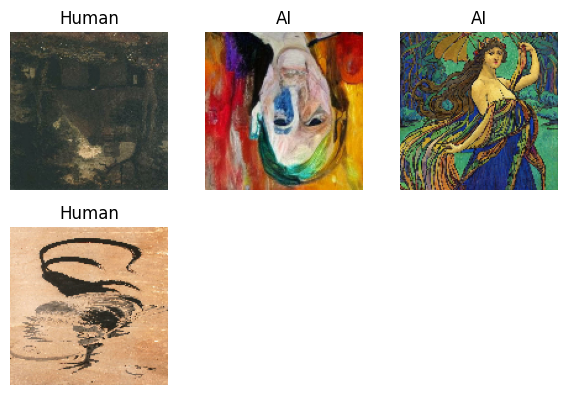

In [18]:
# %%
class_labels = ['Human', 'AI']

def show_batch(ds):
    imgs, labs = next(iter(ds))
    plt.figure(figsize=(6,6))
    for i in range(min(9, imgs.shape[0])):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(imgs[i].numpy())
        plt.title(class_labels[int(labs[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_ds)


#### 9. Custom CNN Model Architecture
Define and initialize a custom convolutional neural network with dropout and regularization.


In [19]:
# %%
from tensorflow.keras import layers, models, regularizers

def build_custom_cnn(input_shape=(*IMG_SIZE, 3), num_classes=2):
    return models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32,3,activation='relu',padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu',padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        layers.Conv2D(128,3,activation='relu',padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

model = build_custom_cnn()
model.summary()


C:\Users\bdrab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,938 (16.36 MB)

 Trainable params: 4,287,938 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

#### 10. Compile and Train the Model
Compile the CNN with loss and optimizer, and train it using early stopping and checkpointing.


In [20]:
# %%
from tensorflow.keras import optimizers, callbacks

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("custom_cnn_best_model.keras", save_best_only=True, monitor="val_accuracy")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
54399/54399 ━━━━━━━━━━━━━━━━━━━━ 1349s 25ms/step - accuracy: 0.7538 - loss: 0.5489 - val_accuracy: 0.8453 - val_loss: 0.4100
Epoch 2/10
54399/54399 ━━━━━━━━━━━━━━━━━━━━ 1752s 32ms/step - accuracy: 0.8341 - loss: 0.4224 - val_accuracy: 0.8497 - val_loss: 0.3934
Epoch 3/10
54399/54399 ━━━━━━━━━━━━━━━━━━━━ 1516s 28ms/step - accuracy: 0.8470 - loss: 0.3993 - val_accuracy: 0.8619 - val_loss: 0.3608
Epoch 4/10
54399/54399 ━━━━━━━━━━━━━━━━━━━━ 1596s 29ms/step - accuracy: 0.8579 - loss: 0.3775 - val_accuracy: 0.8811 - val_loss: 0.3299
Epoch 5/10
54399/54399 ━━━━━━━━━━━━━━━━━━━━ 1620s 30ms/step - accuracy: 0.8707 - loss: 0.3508 - val_accuracy: 0.8731 - val_loss: 0.3458
Epoch 6/10
54399/54399 ━━━━━━━━━━━━━━━━━━━━ 1673s 31ms/step - accuracy: 0.8834 - loss: 0.3294 - val_accuracy: 0.8653 - val_loss: 0.3439
Epoch 7/10
54399/54399 ━━━━━━━━━━━━━━━━━━━━ 1755s 32ms/step - accuracy: 0.8903 - loss: 0.3142 - val_accuracy: 0.8094 - val_loss: 0.4159


#### 11. Final Evaluation and Metrics
Evaluate the best model on the test set and print accuracy, precision, recall, and confusion matrix.


6800/6800 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.8814 - loss: 0.3335

Test Loss: 0.3346    Test Accuracy: 0.8800

Classification Report:
              precision    recall  f1-score   support

       Human       0.84      0.75      0.79      8145
          AI       0.90      0.94      0.92     19055

    accuracy                           0.88     27200
   macro avg       0.87      0.84      0.85     27200
weighted avg       0.88      0.88      0.88     27200



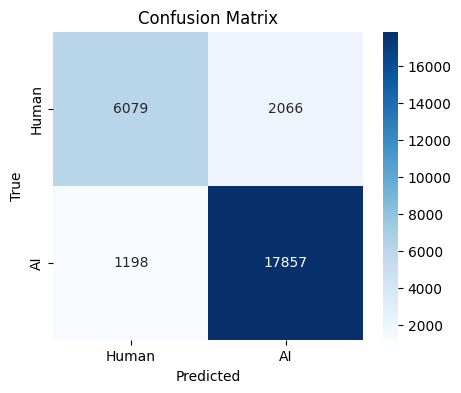

In [21]:
# %% [markdown]
#### 11. Final Evaluation and Metrics

# %%
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# 1) Load best checkpoint
best_model = load_model("custom_cnn_best_model.keras")

# 2) Evaluate overall loss & accuracy
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\nTest Loss: {test_loss:.4f}    Test Accuracy: {test_acc:.4f}")

# 3) Predictions + true labels (robust for batched datasets)
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 4) Classification report
class_labels = ['Human','AI']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 5) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### 12. Plotting Learning Curves
Visualize model performance over epochs for both training and validation sets.


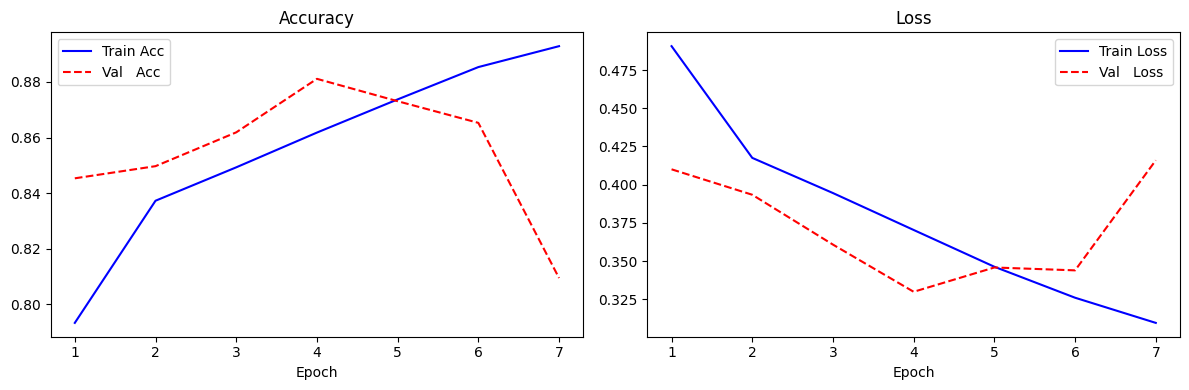

In [22]:
# %%
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc)+1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc,    'b-',  label='Train Acc')
plt.plot(epochs, val_acc,'r--', label='Val   Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss,    'b-',  label='Train Loss')
plt.plot(epochs, val_loss,'r--', label='Val   Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
